# Full simulation in Basin

### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# plt.rcParams["lines.color"] = "w"
# plt.rcParams["text.color"] = "w"
# plt.rcParams["axes.labelcolor"] = "w"
# plt.rcParams["xtick.color"] = "w"
# plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

import pycuda.driver as cuda

GPU Ocean-modules:

In [2]:
from gpuocean.utils import IPythonMagic, Common
from gpuocean.SWEsimulators import CDKLM16, ModelErrorKL

In [3]:
%cuda_context_handler gpu_ctx

In [4]:
gpu_stream = cuda.Stream()

Utils

In [5]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
from utils.BasinInit import *
from utils.BasinPlot import * 

### Collecting Perturbations

In [6]:
from utils.BasinParameters import *

In [7]:
sim_model_error_basis_args["kl_scaling"] = 0.02
init_model_error_basis_args["kl_scaling"] = 0.1

In [8]:
L = 9

In [9]:
grid_args = initGridSpecs(L)

args = {"nx": grid_args["nx"],
        "ny": grid_args["ny"],
        "dx": grid_args["dx"],
        "dy": grid_args["dy"],
        "gpu_ctx": gpu_ctx,
        "boundary_conditions": Common.BoundaryConditions(2,2,2,2)
        }

In [10]:
init_mekl = ModelErrorKL.ModelErrorKL(**args, **init_model_error_basis_args, gpu_stream=gpu_stream) 

In [11]:
data_args=  make_init_steady_state(args, a=steady_state_bump_a, bump_fractal_dist=steady_state_bump_fractal_dist)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

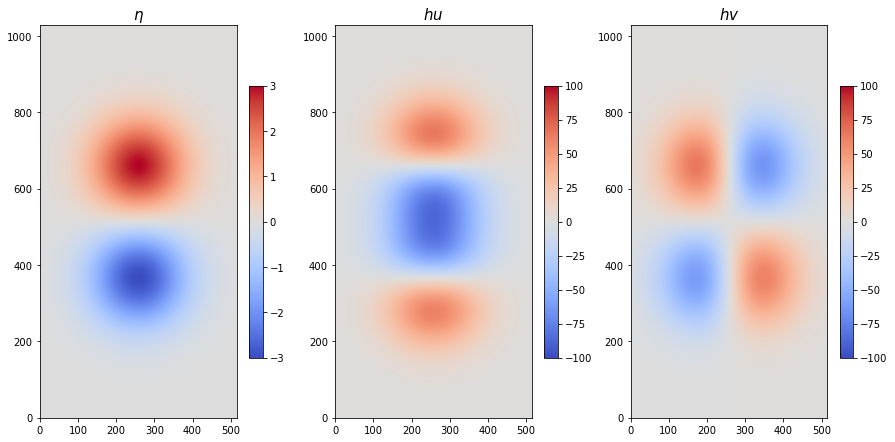

In [12]:
imshow3([data_args["eta"], data_args["hu"], data_args["hv"]], eta_vlim=3, huv_vlim=100)

### Defining Simulations

In [13]:
sim = make_sim(args, sample_args, data_args)
init_mekl.perturbSim(sim)
sim.setKLModelError(**sim_model_error_basis_args)
sim.model_time_step = sim_model_error_timestep

In [14]:
from utils.BasinSL import *

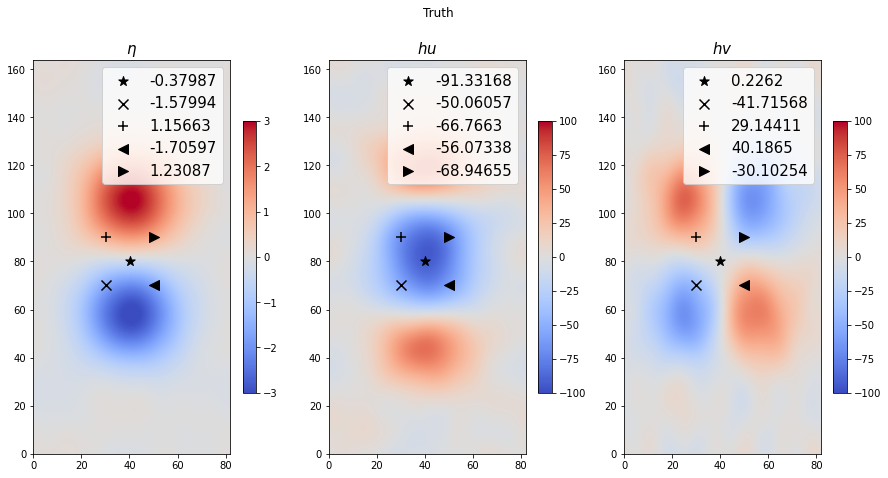

In [15]:
true_eta_init, true_hu_init, true_hv_init = sim.download(interior_domain_only=True)

domain_extent = [0, args["nx"]*args["dx"]/1000, 0, args["ny"]*args["dy"]/1000]
markers = ["*", "x", "+", "<", ">"]
fig, axs = imshow3([true_eta_init, true_hu_init, true_hv_init], eta_vlim=3, huv_vlim=100, extent=domain_extent)
for h, [obs_x, obs_y] in enumerate(zip(obs_xs, obs_ys)):
    Hx, Hy = SLobsCoord2obsIdx(sim, obs_x, obs_y)
    obs = [true_eta_init[Hy,Hx], true_hu_init[Hy,Hx], true_hv_init[Hy,Hx]] + np.random.normal(0,R)

    axs[0].scatter(obs_x/1000,obs_y/1000, marker=markers[h], c="black", label=str(round(obs[0],5)), s=100)
    axs[0].legend(labelcolor="black", fontsize=15)
    axs[1].scatter(obs_x/1000,obs_y/1000, marker=markers[h], c="black", label=str(round(obs[1],5)), s=100)
    axs[1].legend(labelcolor="black", fontsize=15)
    axs[2].scatter(obs_x/1000,obs_y/1000, marker=markers[h], c="black", label=str(round(obs[2],5)), s=100)
    axs[2].legend(labelcolor="black", fontsize=15)
    fig.suptitle("Truth", y=0.85)

In [16]:
ref_sim = make_sim(args, sample_args, data_args)
ref_sim.upload(np.pad(true_eta_init,((2,2),(2,2))), np.pad(true_hu_init,((2,2),(2,2))), np.pad(true_hv_init,((2,2),(2,2))))
ref_sim.setKLModelError(**sim_model_error_basis_args)

In [17]:
for i in range(int(6*3600/sim_model_error_timestep)):
    sim.step(sim_model_error_timestep, apply_stochastic_term=False, write_now=False)
    sim.perturbState()
    ref_sim.perturbSimilarAs(sim)

In [18]:
# sim.dataAssimilationStep(6*3600)

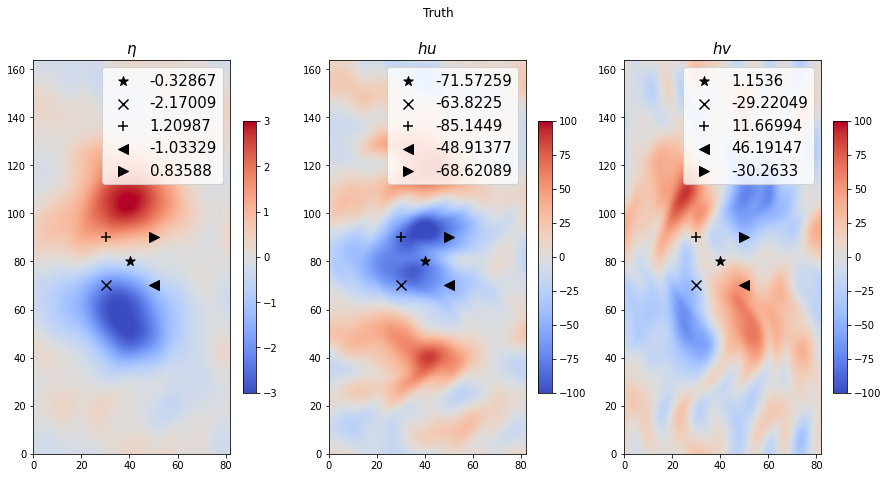

In [19]:
true_eta, true_hu, true_hv = sim.download(interior_domain_only=True)

domain_extent = [0, args["nx"]*args["dx"]/1000, 0, args["ny"]*args["dy"]/1000]
markers = ["*", "x", "+", "<", ">"]
fig, axs = imshow3([true_eta, true_hu, true_hv], eta_vlim=3, huv_vlim=100, extent=domain_extent)
for h, [obs_x, obs_y] in enumerate(zip(obs_xs, obs_ys)):
    Hx, Hy = SLobsCoord2obsIdx(sim, obs_x, obs_y)
    obs = [true_eta[Hy,Hx], true_hu[Hy,Hx], true_hv[Hy,Hx]] + np.random.normal(0,R)

    axs[0].scatter(obs_x/1000,obs_y/1000, marker=markers[h], c="black", label=str(round(obs[0],5)), s=100)
    axs[0].legend(labelcolor="black", fontsize=15)
    axs[1].scatter(obs_x/1000,obs_y/1000, marker=markers[h], c="black", label=str(round(obs[1],5)), s=100)
    axs[1].legend(labelcolor="black", fontsize=15)
    axs[2].scatter(obs_x/1000,obs_y/1000, marker=markers[h], c="black", label=str(round(obs[2],5)), s=100)
    axs[2].legend(labelcolor="black", fontsize=15)
    fig.suptitle("Truth", y=0.85)

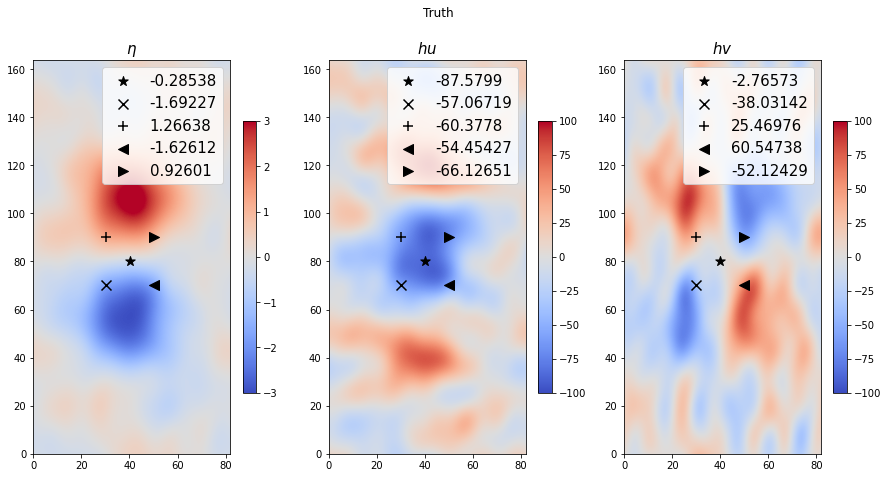

In [24]:
ref_eta, ref_hu, ref_hv = ref_sim.download(interior_domain_only=True)

domain_extent = [0, args["nx"]*args["dx"]/1000, 0, args["ny"]*args["dy"]/1000]
markers = ["*", "x", "+", "<", ">"]
fig, axs = imshow3([ref_eta, ref_hu, ref_hv], eta_vlim=3, huv_vlim=100, extent=domain_extent)
for h, [obs_x, obs_y] in enumerate(zip(obs_xs, obs_ys)):
    Hx, Hy = SLobsCoord2obsIdx(sim, obs_x, obs_y)
    obs = [ref_eta[Hy,Hx], ref_hu[Hy,Hx], ref_hv[Hy,Hx]] + np.random.normal(0,R)

    axs[0].scatter(obs_x/1000,obs_y/1000, marker=markers[h], c="black", label=str(round(obs[0],5)), s=100)
    axs[0].legend(labelcolor="black", fontsize=15)
    axs[1].scatter(obs_x/1000,obs_y/1000, marker=markers[h], c="black", label=str(round(obs[1],5)), s=100)
    axs[1].legend(labelcolor="black", fontsize=15)
    axs[2].scatter(obs_x/1000,obs_y/1000, marker=markers[h], c="black", label=str(round(obs[2],5)), s=100)
    axs[2].legend(labelcolor="black", fontsize=15)
    fig.suptitle("Truth", y=0.85)

In [23]:
sim.t

21600.0

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

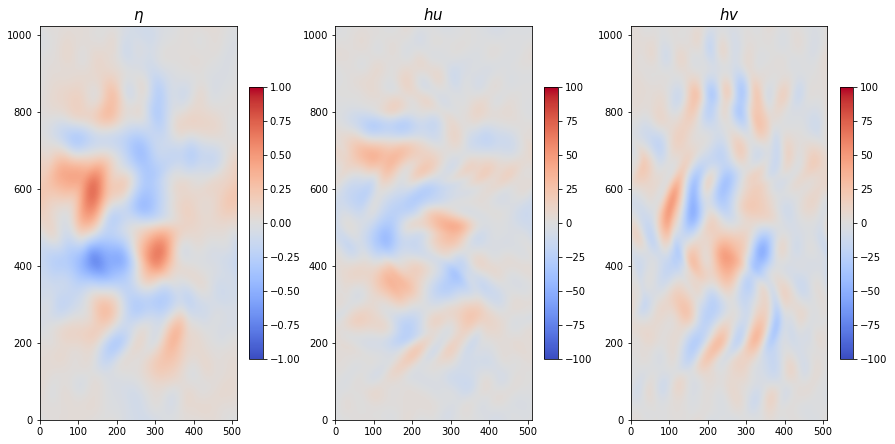

In [28]:
imshow3([true_eta-ref_eta, true_hu-ref_hu, true_hv-ref_hv], eta_vlim=1, huv_vlim=100)

Reference where we run simulation from same initial perturbations, but without model error

In [ ]:
sim2 = make_sim(args, sample_args, data_args)
sim2.upload(np.pad(true_eta_init,((2,2),(2,2))), np.pad(true_hu_init,((2,2),(2,2))), np.pad(true_hv_init,((2,2),(2,2))))

In [ ]:
sim2.step(6*3600)

In [ ]:
eta, hu, hv = sim2.download(interior_domain_only=True)

domain_extent = [0, args["nx"]*args["dx"]/1000, 0, args["ny"]*args["dy"]/1000]
markers = ["*", "x", "+", "<", ">"]
fig, axs = imshow3([eta, hu, hv], eta_vlim=3, huv_vlim=100, extent=domain_extent)
for h, [obs_x, obs_y] in enumerate(zip(obs_xs, obs_ys)):
    Hx, Hy = SLobsCoord2obsIdx(sim, obs_x, obs_y)
    obs = [eta[Hy,Hx], hu[Hy,Hx], hv[Hy,Hx]] + np.random.normal(0,R)

    axs[0].scatter(obs_x/1000,obs_y/1000, marker=markers[h], c="black", label=str(round(obs[0],5)), s=100)
    axs[0].legend(labelcolor="black", fontsize=15)
    axs[1].scatter(obs_x/1000,obs_y/1000, marker=markers[h], c="black", label=str(round(obs[1],5)), s=100)
    axs[1].legend(labelcolor="black", fontsize=15)
    axs[2].scatter(obs_x/1000,obs_y/1000, marker=markers[h], c="black", label=str(round(obs[2],5)), s=100)
    axs[2].legend(labelcolor="black", fontsize=15)
    # fig.suptitle("Truth", y=0.85)